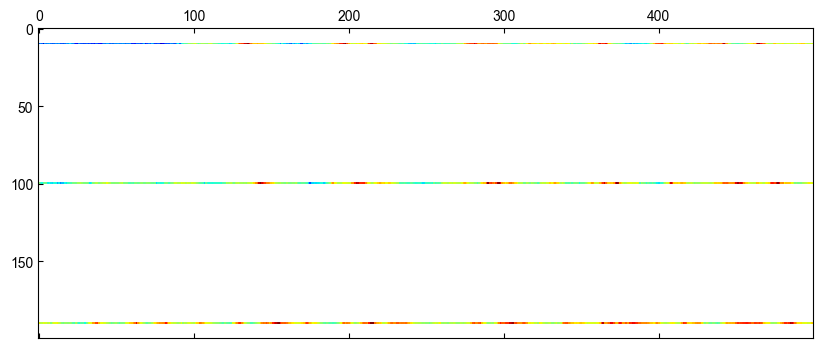

In [1]:
import numpy as np

from functions import *
path = '..//data//NGSIM//npy//'
full = np.load(path+'speed_grid_full.npy')
full = fill_nan(full)

# Set detector location and plot it
d_loc = [10, 100, 190]
observed = np.NAN * np.zeros(full.shape)
observed[d_loc, :] = full[d_loc, :]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(observed, cmap='jet_r', vmax=full.max(), vmin=full.min())


loc[10, 100, 190]_Directional_Matern52_N200_maxiter700. theta: 0.108, lengthscale: [270.80704799  12.76033958], time: 74.544
Train mae: 3.143, rmse: 4.066. Test mae: 4.400, rmse: 5.592. Test mae2: 4.353, rmse2: 5.570.


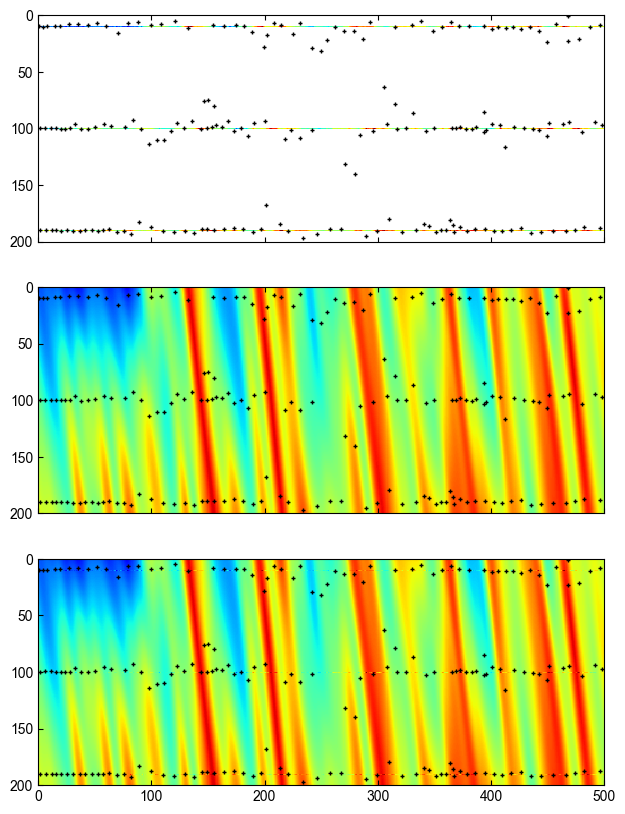

In [6]:
n = 200  # number of inducing points
maxiter = 700
kernel = Matern52

mask = ~np.isnan(observed)

train_X = np.where(mask == 1)
train_Y = observed[train_X].reshape(-1, 1)
train_X = np.concatenate([x.reshape([-1, 1]) for x in train_X], axis = 1)
train_X = train_X.astype(np.float64)

mean_Y = np.mean(train_Y)
std_Y = np.std(train_Y)
train_Y  = (train_Y - mean_Y) / std_Y  # standardize
vmax = full.max()
vmin = full.min()

Z = np.random.permutation(train_X)[:n, :]  # inducing inputs
kernel = Directional_Kernel(Matern52, lengthscales=[150.0, 13.0], theta=0.18, variance=0.2)
model = gpflow.models.SGPR(data=(train_X, train_Y), kernel=kernel, mean_function=None,
                           inducing_variable=Z, noise_variance=0.3)
# model.training_loss()
# print_summary(model)

# define monitor
test_name = f"loc{d_loc}_{model.kernel.name}_N{n}_maxiter{maxiter}"
log_dir_compiled = "logs/fit/" + test_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_task = ModelToTensorBoard(log_dir_compiled, model)
lml_task = ScalarToTensorBoard(
    log_dir_compiled, lambda: model.training_loss(), "training_objective")
# Note that the `ImageToTensorBoard` task cannot be compiled, and is omitted from the monitoring
monitor = Monitor(MonitorTaskGroup(lml_task))

time0 = time.time()
# print(f'Start training {test_name} at', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time0)))
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter),
                        step_callback=monitor)
# print(f'End training {test_name} at', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time.time())))

# Examine the results
test_X = np.where(full >= 0)
test_X = np.concatenate([x.reshape([-1, 1]) for x in test_X], axis=1)
test_X = test_X.astype(np.float64)
test_Y = model.predict_y(test_X)[0]

predicted_Y = test_Y.numpy().reshape(full.shape) * std_Y + mean_Y
predicted_Y2 = predicted_Y.copy()  # The prediction with observed location unchanged
predicted_Y2[mask] = observed[mask]

train_mae = mae(predicted_Y[mask], full[mask])
train_rmse = rmse(predicted_Y[mask], full[mask])
test_mae = mae(predicted_Y, full)
test_rmse = rmse(predicted_Y, full)
test_mae2 = mae(predicted_Y2, full)
test_rmse2 = rmse(predicted_Y2, full)

print(f'{test_name}. theta: {model.kernel.theta.numpy():.3f}, '
      f'lengthscale: {model.kernel.lengthscale.numpy()}, time: {time.time()-time0:.3f}')
print(f'Train mae: {train_mae:.3f}, rmse: {train_rmse:.3f}. Test mae: {test_mae:.3f}, rmse: {test_rmse:.3f}. '
      f'Test mae2: {test_mae2:.3f}, rmse2: {test_rmse2:.3f}.')

lengthscale = model.kernel.lengthscale.numpy()
test_name = test_name + f'_mae{test_mae:.3f}_rmse{test_rmse:.3f}' + \
            f'theta{model.kernel.theta.numpy():.3f}_lengthscale{lengthscale[0]:.3f}_{lengthscale[1]:.3f}'

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
# ax[0].matshow(full, cmap='jet_r', vmax=vmax, vmin=vmin, origin='lower') # plot the full data
Z = model.inducing_variable.Z.numpy()
ax[0].matshow(observed,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the observed data
ax[0].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[1].matshow(predicted_Y,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the prediction
ax[1].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[2].matshow(predicted_Y2,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the observed data
ax[2].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[2].xaxis.set_ticks_position('bottom')
ax[2].set_xbound(0, 500)
ax[2].set_ybound(0, 200)
# save the figure
# fig.savefig(f'..//figure/{test_name}.pdf', bbox_inches='tight')

# Save the model
# save_pickle(gpflow.utilities.parameter_dict(model), f'..//model/{test_name}.pkl')
# model = load_pickle(f'..//model/{test_name}.pkl')
# param = load_pickle(f'..//model/{test_name}_d.pkl')


In [4]:
savemat(f'../result/outputs/detector_GP_rotated_NGSIM.mat', {'pre_mean': predicted_Y}, do_compression=True)